# Big Data: Problem Set 3

### Danya Littlefield

#### Deliverables

**1** - Using the Twitter REST API, collect Tweets from Boston for 30 min. Note how you set the time in the above example (in the **run_all()** function), it was in seconds. How would you do that here? 

**2** - Create a Pie Chart showing a summary of tweets by user location. Please clean up the data so that multiple variations of the same location name are replaced with one variation.

**3** - Create a Scatterplot showing all of the tweets that had a latitude and longitude.

**4** - Pick a search term, such as *Trump* or *#Trump* and collect 15 minutes of tweets on it. Use the same lat/lon for Boston as you used above.

**5** - Export the entirety of your scraped Twitter datasets (one with a search term, one without) to two CSV files. We will be checking this CSV file for duplicates. So clean your file.  

In [3]:
# Import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import api_key, api_secret

In [ ]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

In [3]:
# Input the search term you want to search on
search_term='' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[42.354046, -71.068202] # A point on the Boston Common
# Setup a search distance
distance='15mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=15


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Mar 10 04:53:14 +0000 2017',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 840062970780569601,
  'id_str': '840062970780569601',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'zh',
  'metadata': {'iso_language_code': 'zh', 'result_type': 'recent'},
  'place': None,
  'retweet_count': 0,
  'retweeted': False,
  'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
  'text': 'ËΩ¶Èì∫‰Ω†‰ª¨ÊÉ≥ÈªëÈí±ËÉΩ‰∏çËÉΩÊ≥®ÊÑè‰∏Ä‰∏ãÊäÄÊúØÂê´ÈáèÔºåpart numberÈÉΩÊâìÂá∫Êù•ÊòØ‰∏™‰∫∫Â∞±ËÉΩgoogle‰Ω†‰ª¨Èªë‰∫ÜÂ§öÂ∞ëÈí±...',
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Thu Feb 26 22:45:46 +0000 2009',
   '

I'm going to set up the rest of the data scraper as in the tutorial.

In [4]:
# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 1800
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 30
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

Now I'm going to add the run_all function and set it up so that it grabs new tweets for 30 minutes!

In [5]:
# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 13 new tweets, for a total of 13
At 0 seconds, added 13 new tweets, for a total of 13
At 30 seconds, added 14 new tweets, for a total of 27
At 0 seconds, added 14 new tweets, for a total of 14
At 30 seconds, added 14 new tweets, for a total of 28
At 0 seconds, added 14 new tweets, for a total of 14
At 30 seconds, added 15 new tweets, for a total of 29
At 60 seconds, added 14 new tweets, for a total of 43
At 90 seconds, added 15 new tweets, for a total of 58
At 120 seconds, added 15 new tweets, for a total of 73
At 150 seconds, added 13 new tweets, for a total of 86
At 180 seconds, added 12 new tweets, for a total of 98
At 210 seconds, added 15 new tweets, for a total of 113
At 240 seconds, added 15 new tweets, for a total of 128
At 270 seconds, added 14 new tweets, for a total of 142
At 300 seconds, added 15 new tweets, for a total of 157
At 0 seconds, added 15 new tweets, for a total of 15
At 30 seconds, added 15 new tweets, for a total of 30
At 60 seconds, added 1

Explore and clean the data with Pandas.

In [4]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# Get the file names from a given directory
file_dir = "data" 
# Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
bos_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                bos_tweets.loc[key,val] = val
                
bos_tweets

tweet_id      lat      lon  \
840004570260594689  840004570260594689     None     None   
840004570155765760  840004570155765760     None     None   
840004569904091137  840004569904091137     None     None   
840004569354629121  840004569354629121     None     None   
840004569136525313  840004569136525313     None     None   
840004568901644288  840004568901644288     None     None   
840004568616488960  840004568616488960     None     None   
840004565739147265  840004565739147265     None     None   
840004565646860290  840004565646860290     None     None   
840004565542027266  840004565542027266     None     None   
840004564359270400  840004564359270400     None     None   
840004564128526342  840004564128526342     None     None   
840004563801391106  840004563801391106     None     None   
840004563172249600  840004563172249600     None     None   
840004562891231239  840004562891231239     None     None   
840004695791939585  840004695791939585     None     None   
840004694974091266  840004694974091266     None     None   
840004693321515012  840004693321515012     None     None   
840004691614359552  840004691614359552     None     None   
840004691023003648  840004691023003648     None     None   
840004690788122631  840004690788122631     None     None   
840004690649653248  840004690649653248     None     None   
840004689999593472  840004689999593472     None     None   
840004689181724672  840004689181724672     None     None   
840004688334454784  840004688334454784     None     None   
840004688275787776  840004688275787776     None     None   
840004688217018369  840004688217018369     None     None   
840004686199570432  840004686199570432     None     None   
840004686161825792  840004686161825792     None     None   
840004685092261890  840004685092261890     None     None   
...                                ...      ...      ...   
840011917737500677  840011917737500677     None     None   
840011917024473090  840011917024473090     None     None   
840011916810571776  840011916810571776     None     None   
840011915048951808  840011915048951808     None     None   
840011914247864320  840011914247864320     None     None   
840011913912291332  840011913912291332     None     None   
840011913513881600  840011913513881600     None     None   
840011913417379840  840011913417379840     None     None   
840011913350266880  840011913350266880     None     None   
840011913308307456  840011913308307456     None     None   
840011912460951553  840011912460951553     None     None   
840011912364621824  840011912364621824     None     None   
840011911521587200  840011911521587200     None     None   
840011910305202177  840011910305202177     None     None   
840011909424390144  840011909424390144     None     None   
840012043235295232  840012043235295232     None     None   
840012041758859265  840012041758859265     None     None   
840012041591087104  840012041591087104     None     None   
840012040588664832  840012040588664832 -71.0436  42.3463   
840012039942754310  840012039942754310     None     None   
840012038671892481  840012038671892481     None     None   
840012038361513984  840012038361513984     None     None   
840012037761703936  840012037761703936     None     None   
840012036843196417  840012036843196417     None     None   
840012036226592768  840012036226592768     None     None   
840012034544668673  840012034544668673     None     None   
840012033701617665  840012033701617665     None     None   
840012032908939264  840012032908939264     None     None   
840012032481087489  840012032481087489     None     None   
840012032002908160  840012032002908160     None     None   

                                                              content  \
840004570260594689  Thursday, March 16 at 1pm in the Loft - the Dr...   
840004570155765760  RT @sethmoulton: Ryan's "alternative" is the A...   
840004569904091137  RT @BINJreports: SANCTUARY CITIES FIGHT POINTS...   
84000456935462912

In [7]:
bos_tweets.dtypes

tweet_id      object
lat           object
lon           object
content       object
location      object
user          object
raw_source    object
data_point    object
time          object
dtype: object

In [8]:
bos_tweets['location'].unique()

array(['Boston, MA', '', 'In the Trap', 'France/Mauritania ', 'Virgo',
       'Boston', 'boston, ma', 'Norwood, MA', 'Plymouth, MA',
       'Weymouth, MA', 'california', 'Cambridge, MA', 'Chelsea',
       'Misiones, Argentina', 'Definitely not the gym', 'MA',
       'Haverhill, MA', 'Charlestown, MA', 'Boston Ma', 'Dedham, MA USA',
       'Sheffield, England', 'New York, NY', 'United States',
       'Winthrop, MA', 'Bad Gastein, Austria', 'The Lab',
       'Los Angeles, CA', 'La Romana, Rep. Dom.', 'Dorchester, Boston ',
       'Chicago', 'Oklahoma', 'Boston,MA', 'Somerville, MA',
       'SICK SAD WORLD', 'Nashville, TN', 'bear kitchen',
       'Smokin broccoli', 'where is a famous dog place', 'Florida, USA',
       'Capiat√°', 'Boston, Ma', 'Boston, Massachusetts, USA.',
       'Detroit, MI', 'A Zimbabwean In Milwaukee ', 'Boston, MA ',
       "At world's end", 'NYC / Huddersfield UK', 'Weymouth',
       'South Hill, WA', 'boston ', 'South Boston, MA', 'Medford,Ma',
       'CENTRAL RI

In [24]:
# Cleaning this data!

bos_tweets['location'].replace(to_replace='Boston', value='Boston, MA', 
                               inplace=True)

bos_tweets['location'].replace(to_replace='boston, ma', value='Boston, MA', 
                               inplace=True)

bos_tweets['location'].replace(to_replace='Boston, Ma', value='Boston, MA', 
                               inplace=True)

bos_tweets['location'].replace(to_replace='Boston Ma', value='Boston, MA', 
                               inplace=True)

bos_tweets['location'].replace(to_replace='^.*[Bb]oston.*$', value='Boston, MA', 
                               inplace=True, regex=True)

bos_tweets['location'].replace(to_replace='^.*[Cc]ambridge.*$', value='Cambridge, MA', 
                               inplace=True, regex=True)

bos_tweets['location'].replace(to_replace='^.*[Ss]omerville.*$', value='Somerville, MA', 
                               inplace=True, regex=True)

bos_tweets['location'].replace(to_replace='^.*[Ss]alem.*$', value='Salem, MA', 
                               inplace=True, regex=True)

bos_tweets['location'].unique()



array(['Boston, MA', '', 'In the Trap', 'France/Mauritania ', 'Virgo',
       'Norwood, MA', 'Plymouth, MA', 'Weymouth, MA', 'california',
       'Cambridge, MA', 'Chelsea', 'Misiones, Argentina',
       'Definitely not the gym', 'MA', 'Haverhill, MA', 'Charlestown, MA',
       'Dedham, MA USA', 'Sheffield, England', 'New York, NY',
       'United States', 'Winthrop, MA', 'Bad Gastein, Austria', 'The Lab',
       'Los Angeles, CA', 'La Romana, Rep. Dom.', 'Chicago', 'Oklahoma',
       'Somerville, MA', 'SICK SAD WORLD', 'Nashville, TN', 'bear kitchen',
       'Smokin broccoli', 'where is a famous dog place', 'Florida, USA',
       'Capiat√°', 'Detroit, MI', 'A Zimbabwean In Milwaukee ',
       "At world's end", 'NYC / Huddersfield UK', 'Weymouth',
       'South Hill, WA', 'Medford,Ma', 'CENTRAL RICH ‚ú®', 'Austin, Texas',
       'Sunnyvale, CA', 'Waukesha, Wisconsin', 'Invivienda,RD',
       'Pocumtuc/Abenaky borderlands', 'Vancouver, BC, Canada',
       'Frankfurt / Germany', 'The Mil

In [27]:
bos_tweets.drop_duplicates(['tweet_id'])

tweet_id      lat      lon  \
840004570260594689  840004570260594689     None     None   
840004570155765760  840004570155765760     None     None   
840004569904091137  840004569904091137     None     None   
840004569354629121  840004569354629121     None     None   
840004569136525313  840004569136525313     None     None   
840004568901644288  840004568901644288     None     None   
840004568616488960  840004568616488960     None     None   
840004565739147265  840004565739147265     None     None   
840004565646860290  840004565646860290     None     None   
840004565542027266  840004565542027266     None     None   
840004564359270400  840004564359270400     None     None   
840004564128526342  840004564128526342     None     None   
840004563801391106  840004563801391106     None     None   
840004563172249600  840004563172249600     None     None   
840004562891231239  840004562891231239     None     None   
840004695791939585  840004695791939585     None     None   
840004694974091266  840004694974091266     None     None   
840004693321515012  840004693321515012     None     None   
840004691614359552  840004691614359552     None     None   
840004691023003648  840004691023003648     None     None   
840004690788122631  840004690788122631     None     None   
840004690649653248  840004690649653248     None     None   
840004689999593472  840004689999593472     None     None   
840004689181724672  840004689181724672     None     None   
840004688334454784  840004688334454784     None     None   
840004688275787776  840004688275787776     None     None   
840004688217018369  840004688217018369     None     None   
840004686199570432  840004686199570432     None     None   
840004686161825792  840004686161825792     None     None   
840004685092261890  840004685092261890     None     None   
...                                ...      ...      ...   
840011917737500677  840011917737500677     None     None   
840011917024473090  840011917024473090     None     None   
840011916810571776  840011916810571776     None     None   
840011915048951808  840011915048951808     None     None   
840011914247864320  840011914247864320     None     None   
840011913912291332  840011913912291332     None     None   
840011913513881600  840011913513881600     None     None   
840011913417379840  840011913417379840     None     None   
840011913350266880  840011913350266880     None     None   
840011913308307456  840011913308307456     None     None   
840011912460951553  840011912460951553     None     None   
840011912364621824  840011912364621824     None     None   
840011911521587200  840011911521587200     None     None   
840011910305202177  840011910305202177     None     None   
840011909424390144  840011909424390144     None     None   
840012043235295232  840012043235295232     None     None   
840012041758859265  840012041758859265     None     None   
840012041591087104  840012041591087104     None     None   
840012040588664832  840012040588664832 -71.0436  42.3463   
840012039942754310  840012039942754310     None     None   
840012038671892481  840012038671892481     None     None   
840012038361513984  840012038361513984     None     None   
840012037761703936  840012037761703936     None     None   
840012036843196417  840012036843196417     None     None   
840012036226592768  840012036226592768     None     None   
840012034544668673  840012034544668673     None     None   
840012033701617665  840012033701617665     None     None   
840012032908939264  840012032908939264     None     None   
840012032481087489  840012032481087489     None     None   
840012032002908160  840012032002908160     None     None   

                                                              content  \
840004570260594689  Thursday, March 16 at 1pm in the Loft - the Dr...   
840004570155765760  RT @sethmoulton: Ryan's "alternative" is the A...   
840004569904091137  RT @BINJreports: SANCTUARY CITIES FIGHT POINTS...   
84000456935462912

In [29]:
bos_grouped_tweets = bos_tweets.groupby('location')
bos_count_tweets = bos_grouped_tweets['location'].count()
bos_count_tweets.sort_values(inplace=True, ascending=False)
df_bos_count_tweets = bos_count_tweets.to_frame()
df_bos_count_tweets.columns = ['NUMBER']
df_bos_count_tweets.index.names = ['Location']
df_bos_count_tweets









NUMBER
Location                            
Boston, MA                       342
                                 130
Cambridge, MA                     17
Salem, MA                         13
Somerville, MA                    11
Capiat√°                            8
Massachusetts, USA                 6
United States                      6
Weymouth, MA                       5
Los Angeles, CA                    4
Lynn, MA                           4
Houston, TX                        4
Santiago, Chile                    3
USA                                3
Plymouth, MA                       3
Waltham, MA                        3
Needham, MA                        3
New York                           2
Sydney, Australia                  2
Rockford, IL                       2
Quincy, MA                         2
Wakefield, MA                      2
Phoenix, AZ                        2
Malden, Ma                         2
New Jersey, USA                    2
Massachusetts                      2
Malden                             2
MA                                 2
Lynnfield, MA                      2
India                              2
...                              ...
eastside..                         1
chelsea                            1
Revere                             1
Removing my head from laptop       1
dc ‚Ä¢ sw ‚Ä¢ st ‚Ä¢ books               1
Providence, R.I.                   1
Portland, MAINE                    1
Pocumtuc/Abenaky borderlands       1
Plymouth,Ma                        1
dolo                               1
Pleiades Star System               1
Pittsburgh, PA                     1
Pittsburgh                         1
Pinehurst, MA                      1
Philadelphia                       1
Northwestern CT                    1
Peterborough                       1
Pepperidge Farm                    1
Pennsylvania, USA                  1
Peabody, MA                        1
Ottawa Canada                      1
Ottawa                             1
On Jason Todd                      1
Oklahoma City, OK                  1
Oklahoma                           1
Ohio                               1
Oakland, CA                        1
Not throwing away my shot.         1
Norwood, MA                        1
ÏßπÏßπÏù¥ ÏãúÏûë : 160131 ~ing               1

[298 rows x 1 columns]

In [31]:
locations = ['Boston, MA', 'Blank', 'Cambridge, MA', 'Salem, MA', 
             'Somerville, MA', 'Other']
values = np.array([df_bos_count_tweets[(df_bos_count_tweets.index == 'Boston, MA')].NUMBER.item(),
                   df_bos_count_tweets[(df_bos_count_tweets.index == '')].NUMBER.item(),
                   df_bos_count_tweets[(df_bos_count_tweets.index == 'Cambridge, MA')].NUMBER.item(),
                   df_bos_count_tweets[(df_bos_count_tweets.index == 'Salem, MA')].NUMBER.item(),
                   df_bos_count_tweets[(df_bos_count_tweets.index == 'Somerville, MA')].NUMBER.item(),
                   df_bos_count_tweets[(df_bos_count_tweets.index != 'Boston, MA') & 
                                       (df_bos_count_tweets.index != '') &
                                       (df_bos_count_tweets.index != 'Cambridge, MA') &
                                       (df_bos_count_tweets.index != 'Salem, MA') & 
                                       (df_bos_count_tweets.index != 'Somerville, MA')].NUMBER.sum()])
                                     
df_boslocs = pd.DataFrame(values,index=locations,columns=list('N'))
df_boslocs

N
Boston, MA      342
Blank           130
Cambridge, MA    17
Salem, MA        13
Somerville, MA   11
Other           357

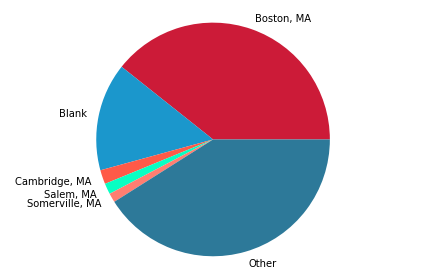

In [33]:
# create a list of colors (from color.Adobe.com)
colors = ["#CC1B38", "#1B97CC", "#FF5A48", 
          "#08FFC3", "#FF7E71", "#2D7999"]

# make a pie
plt.pie( df_boslocs['N'], labels=df_boslocs.index.get_values(), colors=colors)

plt.axis('equal')
plt.tight_layout()
plt.show()


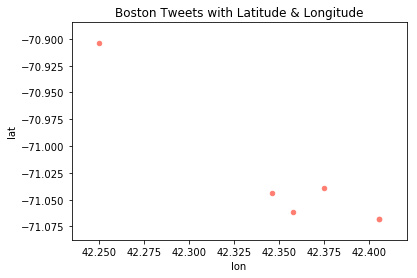

In [36]:
bos_scatter = bos_tweets.plot.scatter(x='lon', y='lat', c=colors[4], title='Boston Tweets with Latitude & Longitude')

In [44]:
#Creating a new scraping tool with a search term and testing it

# Input the search term you want to search on
search_term2='Trump' # SET A SEARCH TERM LIKE 'TRUMP'
# Setup a Lat Lon
latlong2=[42.354046, -71.068202] # A point on the Boston Common
# Setup a search distance
distance2='15mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result2='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets2=15


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location_trump( latlong2=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term2, geocode=str(latlong2[0])+','+str(latlong2[1])+','+ distance2, result_type2=type_of_result2, count=number_of_tweets2)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location_trump(latlong2)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Mar 10 16:53:35 +0000 2017',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 840244250730209280,
  'id_str': '840244250730209280',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'place': None,
  'retweet_count': 0,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'text': 'Trump starting to let me down   Dude wants to cut the budget of the coast guard by 1 billion,   Yeah real smart idea',
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 07 00:28:36 +0000 2012',
   'default_pr

In [45]:
# Does pretty much what its long name suggests.
def get_lots_of_trump_tweets( latlong2 ):
    # Create a dictionary to parse the JSON
    all_tweets_trump = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 30
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets2 = get_tweets_by_location_trump(latlong2) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets2:
            tid = tweet['id']
            if tid not in all_tweets_trump:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets_trump[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets_trump )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets_trump)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets_trump

In [46]:
# This function executes the the functions over a given period of time
def run_trump():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_trump_tweets( latlong2 )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_trump()

At 0 seconds, added 11 new tweets, for a total of 11
At 30 seconds, added 4 new tweets, for a total of 15
At 60 seconds, added 1 new tweets, for a total of 16
At 90 seconds, added 1 new tweets, for a total of 17
At 120 seconds, added 5 new tweets, for a total of 22
At 150 seconds, added 1 new tweets, for a total of 23
At 180 seconds, added 0 new tweets, for a total of 23
At 210 seconds, added 5 new tweets, for a total of 28
At 240 seconds, added 4 new tweets, for a total of 32
At 270 seconds, added 3 new tweets, for a total of 35
At 300 seconds, added 0 new tweets, for a total of 35
At 330 seconds, added 2 new tweets, for a total of 37
At 360 seconds, added 3 new tweets, for a total of 40
At 390 seconds, added 3 new tweets, for a total of 43
At 420 seconds, added 4 new tweets, for a total of 47
At 450 seconds, added 1 new tweets, for a total of 48
At 480 seconds, added 4 new tweets, for a total of 52
At 510 seconds, added 2 new tweets, for a total of 54
At 540 seconds, added 3 new twee

In [47]:
# Get the file names from a given directory
file_dir = "trumptweets" 
# Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
trump_bos_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                trump_bos_tweets.loc[key,val] = val
                
trump_bos_tweets

tweet_id   lat   lon  \
840244250730209280  840244250730209280  None  None   
840244194409103360  840244194409103360  None  None   
840244066373718016  840244066373718016  None  None   
840244047155494912  840244047155494912  None  None   
840243995779424256  840243995779424256  None  None   
840243935582797824  840243935582797824  None  None   
840243884051595264  840243884051595264  None  None   
840243856268509184  840243856268509184  None  None   
840243831211773952  840243831211773952  None  None   
840243687774920705  840243687774920705  None  None   
840243672327286785  840243672327286785  None  None   
840244324289921024  840244324289921024  None  None   
840244317071523840  840244317071523840  None  None   
840244291960242182  840244291960242182  None  None   
840244268556046336  840244268556046336  None  None   
840244512505098240  840244512505098240  None  None   
840244644428599296  840244644428599296  None  None   
840244810271318016  840244810271318016  None  None   
840244709536731137  840244709536731137  None  None   
840244709142454273  840244709142454273  None  None   
840244705065631748  840244705065631748  None  None   
840244695590699009  840244695590699009  None  None   
840244819561721856  840244819561721856  None  None   
840245183518248961  840245183518248961  None  None   
840245155970052096  840245155970052096  None  None   
840245145006141440  840245145006141440  None  None   
840245125787738112  840245125787738112  None  None   
840245123380326400  840245123380326400  None  None   
840245257694515202  840245257694515202  None  None   
840245250870394882  840245250870394882  None  None   
...                                ...   ...   ...   
840246532016373764  840246532016373764  None  None   
840246481969856512  840246481969856512  None  None   
840246710819524609  840246710819524609  None  None   
840246667626594304  840246667626594304  None  None   
840246652933877760  840246652933877760  None  None   
840246652720037888  840246652720037888  None  None   
840246598022123521  840246598022123521  None  None   
840246851756523521  840246851756523521  None  None   
840247087673430016  840247087673430016  None  None   
840247017188278272  840247017188278272  None  None   
840246991078772736  840246991078772736  None  None   
840247186654928896  840247186654928896  None  None   
840247171588927488  840247171588927488  None  None   
840247155499573248  840247155499573248  None  None   
840247144632184832  840247144632184832  None  None   
840247113145581569  840247113145581569  None  None   
840247282771492865  840247282771492865  None  None   
840247274118750208  840247274118750208  None  None   
840247220918202368  840247220918202368  None  None   
840247417832407043  840247417832407043  None  None   
840247487701106688  840247487701106688  None  None   
840247705439993856  840247705439993856  None  None   
840247658547683328  840247658547683328  None  None   
840247642118590468  840247642118590468  None  None   
840247609675677696  840247609675677696  None  None   
840247764080513024  840247764080513024  None  None   
840247964064993280  840247964064993280  None  None   
840247939503136768  840247939503136768  None  None   
840247933819858944  840247933819858944  None  None   
840247910168158209  840247910168158209  None  None   

                                                              content  \
840244250730209280  Trump starting to let me down   Dude wants to ...   
840244194409103360  I'm tired of reading stories abt regretful Tru...   
840244066373718016  RT @JonathanCohn: We're going to have 8 years ...   
840244047155494912  RT @BenjaminPDixon: Poll: Laughably-Unpopular ...   
840243995779424256  Elisabeth Sabaditsch-Wolff, Convicted of Hate ...   
840243935582797824  RT @BenjaminPDixon: Poll: Laughably-Unpopular ...   
840243884051595264  The world knows Trump's a fraud ... when will ...   
840243856268509184  I liked a @YouTube video from @theyoungturks h...   
840243831211773952  @big

In [48]:
trump_bos_tweets.drop_duplicates(['tweet_id'])

tweet_id   lat   lon  \
840244250730209280  840244250730209280  None  None   
840244194409103360  840244194409103360  None  None   
840244066373718016  840244066373718016  None  None   
840244047155494912  840244047155494912  None  None   
840243995779424256  840243995779424256  None  None   
840243935582797824  840243935582797824  None  None   
840243884051595264  840243884051595264  None  None   
840243856268509184  840243856268509184  None  None   
840243831211773952  840243831211773952  None  None   
840243687774920705  840243687774920705  None  None   
840243672327286785  840243672327286785  None  None   
840244324289921024  840244324289921024  None  None   
840244317071523840  840244317071523840  None  None   
840244291960242182  840244291960242182  None  None   
840244268556046336  840244268556046336  None  None   
840244512505098240  840244512505098240  None  None   
840244644428599296  840244644428599296  None  None   
840244810271318016  840244810271318016  None  None   
840244709536731137  840244709536731137  None  None   
840244709142454273  840244709142454273  None  None   
840244705065631748  840244705065631748  None  None   
840244695590699009  840244695590699009  None  None   
840244819561721856  840244819561721856  None  None   
840245183518248961  840245183518248961  None  None   
840245155970052096  840245155970052096  None  None   
840245145006141440  840245145006141440  None  None   
840245125787738112  840245125787738112  None  None   
840245123380326400  840245123380326400  None  None   
840245257694515202  840245257694515202  None  None   
840245250870394882  840245250870394882  None  None   
...                                ...   ...   ...   
840246532016373764  840246532016373764  None  None   
840246481969856512  840246481969856512  None  None   
840246710819524609  840246710819524609  None  None   
840246667626594304  840246667626594304  None  None   
840246652933877760  840246652933877760  None  None   
840246652720037888  840246652720037888  None  None   
840246598022123521  840246598022123521  None  None   
840246851756523521  840246851756523521  None  None   
840247087673430016  840247087673430016  None  None   
840247017188278272  840247017188278272  None  None   
840246991078772736  840246991078772736  None  None   
840247186654928896  840247186654928896  None  None   
840247171588927488  840247171588927488  None  None   
840247155499573248  840247155499573248  None  None   
840247144632184832  840247144632184832  None  None   
840247113145581569  840247113145581569  None  None   
840247282771492865  840247282771492865  None  None   
840247274118750208  840247274118750208  None  None   
840247220918202368  840247220918202368  None  None   
840247417832407043  840247417832407043  None  None   
840247487701106688  840247487701106688  None  None   
840247705439993856  840247705439993856  None  None   
840247658547683328  840247658547683328  None  None   
840247642118590468  840247642118590468  None  None   
840247609675677696  840247609675677696  None  None   
840247764080513024  840247764080513024  None  None   
840247964064993280  840247964064993280  None  None   
840247939503136768  840247939503136768  None  None   
840247933819858944  840247933819858944  None  None   
840247910168158209  840247910168158209  None  None   

                                                              content  \
840244250730209280  Trump starting to let me down   Dude wants to ...   
840244194409103360  I'm tired of reading stories abt regretful Tru...   
840244066373718016  RT @JonathanCohn: We're going to have 8 years ...   
840244047155494912  RT @BenjaminPDixon: Poll: Laughably-Unpopular ...   
840243995779424256  Elisabeth Sabaditsch-Wolff, Convicted of Hate ...   
840243935582797824  RT @BenjaminPDixon: Poll: Laughably-Unpopular ...   
840243884051595264  The world knows Trump's a fraud ... when will ...   
840243856268509184  I liked a @YouTube video from @theyoungturks h...   
840243831211773952  @big

In [49]:
bos_tweets.to_csv('boston_twitter_data.csv', sep=',', encoding='utf-8')
trump_bos_tweets.to_csv('trump_boston_twitter_data.csv', sep=',', encoding='utf-8')